In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
import io
from utils.corruption import *
from simulators.oup import oup
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cpu


In [2]:
matplotlib.rcParams.update({
    'font.family' : 'serif',
    'font.size' : 12.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (5, 4),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : False
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': 'C0', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}

In [3]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior


def read_rnpe(model="oup", var=1.0, degree=0, seed=1, theta=[0.5,1.0]):
    file = f"seed={seed}_degree={degree}_var={var}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])


def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, 25), show_progress_bars=False)

In [4]:
def RMSE(gt, samples, p=1):
    if p == 1:
        dist = torch.mean(torch.abs(gt-samples))
    elif p == 2:
        dist = torch.sqrt(torch.mean((gt-samples)**2))
    elif p == 3:
        dist = torch.nn.functional.pairwise_distance(gt, samples, p=2).mean()
    else:
        dist = metrics.MMD_unweighted(samples, gt.reshape(-1, 2), lengthscale=metrics.median_heuristic(samples))
    return dist

In [9]:
p=2
N=100
simulator = oup(var=1.0, N=N)
theta_gt = torch.tensor([0.5, 1])
obs = simulator(theta_gt).to(device)

x = torch.tensor(np.load("data/oup_x_1000.npy")).to(device)
theta = torch.tensor(np.load("data/oup_theta_1000.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([1000, 2500])
theta shape torch.Size([1000, 2])


# degree = 0

ours:  0.4906148310750723
RNPE:  0.7701074123382569
NPE:  0.5305132031440735


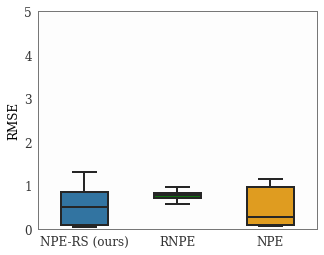

In [10]:
degree = 0
n_corrupted = int(N * degree)
n_normal = int(N - n_corrupted)

theta_cont = torch.tensor([-0.5, 1])

obs_2 = simulator(theta_cont).to(device)
obs_cont = torch.cat([obs[:n_normal], obs_2[:n_corrupted]], dim=0).reshape(-1, N, 25)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/oup_new/degree=0.0_var=1.0_mmd_beta={beta}_theta=[0.5, 1.0]_num=1000_N=100/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/oup_new/var=1.0_none_num=1000_N=100_2/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="oup", var=1, degree=degree, seed=i, theta='[0.5,1.0]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))


x =  30 * ["NPE-RS (ours)"]  + 30* ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours +  dist_rnpe + dist_npe]).reshape(-1)

print("ours: ", sum(dist_ours)/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 5)
plt.savefig("oup_0_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

# degree = 0.1

ours:  0.6004185080528259
RNPE:  0.8537267049153646
NPE:  1.2736432204643886


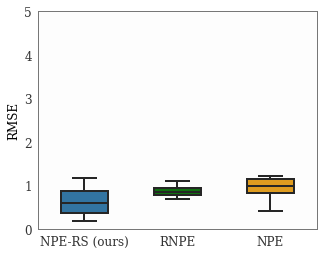

In [11]:
degree = 0.1
n_corrupted = int(N * degree)
n_normal = int(N - n_corrupted)

theta_cont = torch.tensor([-0.5, 1])

obs_2 = simulator(theta_cont).to(device)
obs_cont = torch.cat([obs[:n_normal], obs_2[:n_corrupted]], dim=0).reshape(-1, N, 25)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/oup_new/degree={degree}_var=1.0_mmd_beta={beta}_theta=[0.5, 1.0]_num=1000_N=100/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/oup_new/var=1.0_none_num=1000_N=100_2/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="oup", var=1, degree=degree, seed=i, theta='[0.5,1.0]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))


x =  30 * ["NPE-RS (ours)"]  + 30* ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours +  dist_rnpe + dist_npe]).reshape(-1)

print("ours: ", sum(dist_ours)/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 5)
plt.savefig("oup_0.1_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()

# degree = 0.2

                        prior support. It may take a long time to collect the
                        remaining 923 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


ours:  0.5798994769652684
RNPE:  0.9693045854568482
NPE:  2.0552092413107554


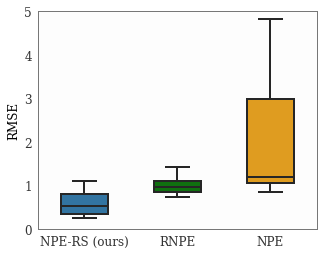

In [12]:
degree = 0.2
n_corrupted = int(N * degree)
n_normal = int(N - n_corrupted)

theta_cont = torch.tensor([-0.5, 1])

obs_2 = simulator(theta_cont).to(device)
obs_cont = torch.cat([obs[:n_normal], obs_2[:n_corrupted]], dim=0).reshape(-1, N, 25)

beta_list = [2.0]
dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 31):
    for beta in beta_list:
        root_name = f"objects/oup_new/degree={degree}_var=1.0_mmd_beta={beta}_theta=[0.5, 1.0]_num=1000_N=100/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        thetas_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        dist_ours.append(float(RMSE(theta_gt, thetas_robust, p=p)))
    
    root_name = f"objects/oup_new/var=1.0_none_num=1000_N=100_2/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_npe = sample_posteriors(posterior_normal, obs_cont, 1000)
    dist_npe.append(float(RMSE(theta_gt, thetas_npe, p=p)))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="oup", var=1, degree=degree, seed=i, theta='[0.5,1.0]'))[:1000]
    dist_rnpe.append(float(RMSE(theta_gt, thetas_rnpe, p=p)))


x =  30 * ["NPE-RS (ours)"]  + 30* ["RNPE"] + 30 * ["NPE"] 
y = np.array([dist_ours +  dist_rnpe + dist_npe]).reshape(-1)

print("ours: ", sum(dist_ours)/30)
print("RNPE: ", sum(dist_rnpe)/30)
print("NPE: ", sum(dist_npe)/30)

my_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
sns.boxplot(x=x, y=y, width=0.5, showfliers = False, palette=my_pal)
# plt.title("RMSE between $\\theta_{true}$ and posterior of $\\theta$")
plt.ylabel("RMSE" if p==2 else "MAE")
plt.ylim(0, 5)
plt.savefig("oup_0.2_rmse.pdf", bbox_inches = 'tight', dpi = 300)
plt.show()